In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

if torch.cuda.is_available():
  device='cuda'
else:
  device='cpu'
print(device)

cuda


In [0]:
vgg19 = models.vgg19(pretrained=True).features.to('cpu').eval()

In [0]:
def import_image(path, size):
  tf = transforms.Compose([transforms.Resize((size, size)), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

  img = Image.open(path).convert('RGB')

  img = tf(img)[:3, :, :].unsqueeze(0)
  return img

def img_to_numpy(img):
  img = img.to('cpu').clone().detach()
  img = img.numpy().squeeze()
  img = img.transpose(1, 2, 0)
  img = img * np.array((0.229, 0.224, 0.225)) + np.array(
  (0.485, 0.456, 0.406))
  img = img.clip(0, 1)
  return img

In [0]:
content_img = import_image('/content/bobo.jpg', 128)
style_img = import_image('/content/asdf.jpg', 128)


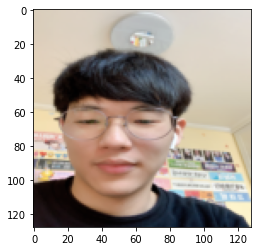

torch.Size([1, 3, 128, 128])


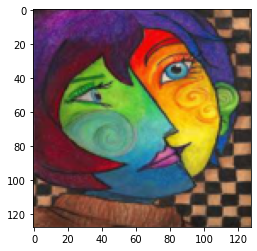

torch.Size([1, 3, 128, 128])


In [5]:
content_np = img_to_numpy(content_img)
plt.imshow(content_np)
plt.show()

style_np = img_to_numpy(style_img)
plt.imshow(style_np)
print(content_img.shape)
plt.show()
print(style_img.shape)

In [6]:
for name, layer in vgg19.named_children():
  print(name)
  print(layer)
  print(type(name))

0
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
<class 'str'>
1
ReLU(inplace=True)
<class 'str'>
2
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
<class 'str'>
3
ReLU(inplace=True)
<class 'str'>
4
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
<class 'str'>
5
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
<class 'str'>
6
ReLU(inplace=True)
<class 'str'>
7
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
<class 'str'>
8
ReLU(inplace=True)
<class 'str'>
9
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
<class 'str'>
10
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
<class 'str'>
11
ReLU(inplace=True)
<class 'str'>
12
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
<class 'str'>
13
ReLU(inplace=True)
<class 'str'>
14
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
<class 'str'>
15
ReLU(inplace=True)

In [0]:
def get_feature(model, img):
  feature = []
  layers = ['0', '10', '19', '28']
  x = img
  for name, layer in model.named_children():
    x = layer(x)
    if name in layers:
      feature.append(x)
  return feature

In [0]:


content_feature = get_feature(vgg19, content_img)
style_feature = get_feature(vgg19, style_img)


In [9]:
for cf in content_feature:
  print(cf.shape)
for sf in style_feature:
  print(sf.shape)

torch.Size([1, 64, 128, 128])
torch.Size([1, 256, 32, 32])
torch.Size([1, 512, 16, 16])
torch.Size([1, 512, 8, 8])
torch.Size([1, 64, 128, 128])
torch.Size([1, 256, 32, 32])
torch.Size([1, 512, 16, 16])
torch.Size([1, 512, 8, 8])


In [0]:
def get_gram_matrix(features):
  gram = []
  for f in features:
    _, c, h, w = f.shape
    f = f.view(c, -1)
    gram.append(torch.mm(f, f.t()))
  return gram

In [0]:
gram_matrix = get_gram_matrix(style_feature)

In [12]:
for gm in gram_matrix:
  print(gm.shape)

torch.Size([64, 64])
torch.Size([256, 256])
torch.Size([512, 512])
torch.Size([512, 512])


In [13]:
in_img = torch.randn((1, 3, 128, 128), device=device, requires_grad=True)
print(in_img)

tensor([[[[-0.1806,  0.2662, -0.5755,  ..., -0.1563, -1.3040,  0.6769],
          [-0.1602, -0.4959, -0.4771,  ...,  1.9332, -0.9243, -0.9716],
          [ 1.3662, -0.8065, -0.1116,  ...,  0.4072,  0.3835, -0.2912],
          ...,
          [ 0.4392,  0.6178,  1.0863,  ..., -1.7030,  1.4584,  1.3325],
          [-1.9581, -0.4156, -0.9911,  ...,  0.5442, -1.9371,  0.1113],
          [ 0.4040,  1.1603, -0.6719,  ...,  1.1020, -0.7617,  0.9664]],

         [[-0.1582,  1.7266, -1.6619,  ...,  0.2757, -2.1617, -0.5479],
          [-0.8689,  0.3456,  1.0349,  ..., -0.9686,  0.6773,  0.5844],
          [ 0.3626, -0.7268, -0.6898,  ...,  0.3323,  0.3975,  0.6566],
          ...,
          [-1.0630,  0.4525, -0.0038,  ..., -0.4412, -0.0497, -0.5618],
          [-0.0947,  0.6133, -0.5153,  ..., -1.7402, -0.3723, -0.2218],
          [ 0.6656,  0.4903,  0.3519,  ...,  0.2836,  0.5256,  0.4091]],

         [[-0.7547, -0.2426, -0.9814,  ...,  1.1797,  0.6414, -0.8763],
          [ 1.2854, -0.4398,  

In [0]:
def get_loss(model, x, content_img, style_img, alpha, beta):


  content_feature = get_feature(model, content_img)
  style_gram = get_gram_matrix(get_feature(model, style_img))

  feature = get_feature(model, x)
  gram = get_gram_matrix(feature)

  weight = torch.tensor([alpha, beta]).to(device)
  
  loss = 0
  loss_fn = nn.MSELoss()

  for cf, sg, f, g in zip(content_feature, style_gram, feature, gram):
    loss += weight[0] * loss_fn(cf, f) + weight[1] * loss_fn(sg, g)
  
  return loss

  0%|          | 0/10000 [00:00<?, ?it/s]

0 epoch : avg loss 349929.25


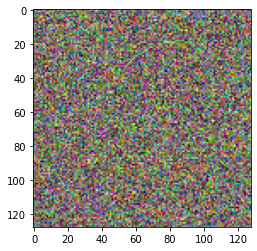

  5%|▍         | 499/10000 [00:12<03:52, 40.80it/s]

500 epoch : avg loss 36510.9609375


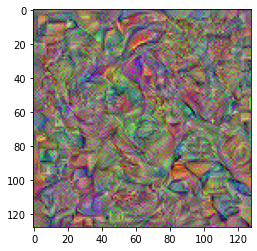

 10%|▉         | 999/10000 [00:24<03:39, 41.09it/s]

1000 epoch : avg loss 13719.240234375


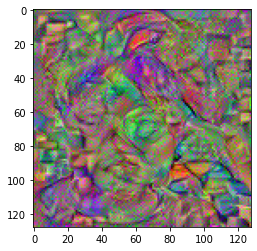

 15%|█▍        | 1498/10000 [00:37<03:26, 41.07it/s]

1500 epoch : avg loss 10202.037109375


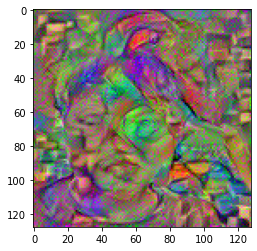

 20%|█▉        | 1997/10000 [00:49<03:15, 40.99it/s]

2000 epoch : avg loss 8686.9482421875


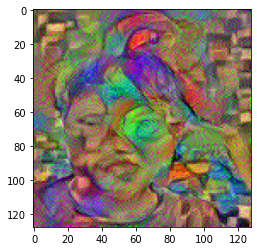

 25%|██▍       | 2497/10000 [01:01<03:02, 41.13it/s]

2500 epoch : avg loss 7738.55078125


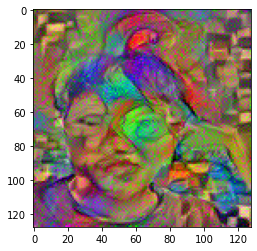

 30%|██▉       | 2996/10000 [01:14<02:50, 41.17it/s]

3000 epoch : avg loss 7062.82763671875


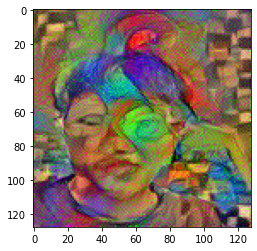

 35%|███▍      | 3496/10000 [01:26<02:38, 41.04it/s]

3500 epoch : avg loss 6632.25537109375


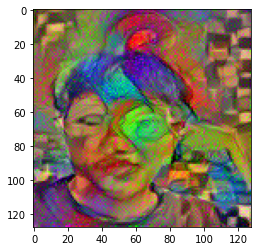

 40%|███▉      | 3996/10000 [01:38<02:26, 40.86it/s]

4000 epoch : avg loss 6323.55517578125


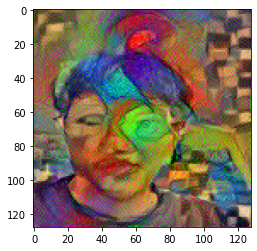

 45%|████▍     | 4496/10000 [01:51<02:14, 40.83it/s]

4500 epoch : avg loss 6081.33740234375


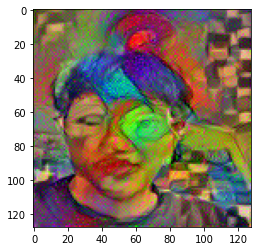

 50%|████▉     | 4996/10000 [02:03<02:01, 41.18it/s]

5000 epoch : avg loss 5883.181640625


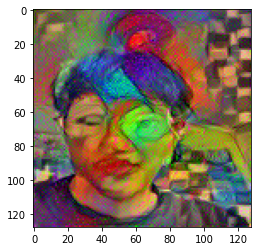

 55%|█████▍    | 5496/10000 [02:16<01:49, 40.98it/s]

5500 epoch : avg loss 5710.1123046875


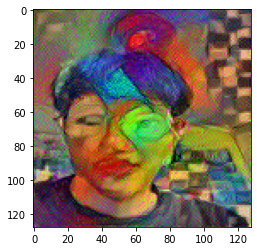

 60%|█████▉    | 5996/10000 [02:28<01:37, 41.15it/s]

6000 epoch : avg loss 5570.3046875


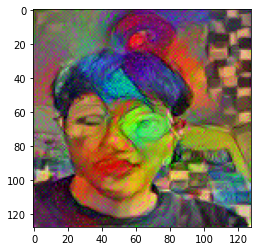

 65%|██████▍   | 6496/10000 [02:40<01:25, 40.76it/s]

6500 epoch : avg loss 5480.45263671875


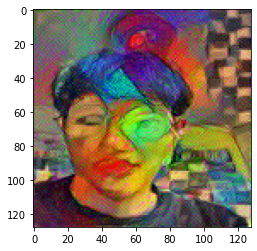

 70%|██████▉   | 6966/10000 [02:52<01:13, 41.19it/s]

KeyboardInterrupt: ignored

In [15]:
from tqdm import trange

in_img = in_img.to(device)
content_img = content_img.to(device)
style_img = style_img.to(device)
vgg19.to(device)

epochs = 10000
print_every = 500
optimizer = optim.Adam([in_img], lr=1e-2)

losses = []
for epoch in trange(epochs):
  optimizer.zero_grad()
  loss = get_loss(vgg19, in_img, content_img, style_img, 100.0, 0.001)

  losses.append(loss)
  if epoch % print_every == 0:
    avg_loss = sum(losses) / len(losses)
    print(f'{epoch} epoch : avg loss {avg_loss}')
    losses = []

    result = in_img.detach().to('cpu')
    result = img_to_numpy(result)
    plt.imshow(result)
    plt.show()

  loss.backward()
  optimizer.step()

print(losses)

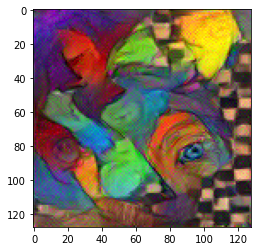

In [39]:
result = in_img.detach().to('cpu')

result = img_to_numpy(result)

plt.imshow(result)
plt.show()